<h1><center>Daily Covid-19 Deaths</center></h1>
From <a href = "https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/">NHS page</a> on Covid-19 deaths.

In [43]:
import requests, bs4, os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=16)

## Find spreadsheet link

In [56]:
root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")

for elem in linkElems:
    url = elem.get('href')
    if "COVID-19-total-announced-deaths" in url and not "weekly" in url:
        link = url

print("Link:", link)

Link: https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/11/COVID-19-total-announced-deaths-20-November-2020.xlsx


## Load Spreadsheet

In [50]:
resp = requests.get(link)

# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()

sheet = pd.read_excel('tempfile.xls', sheet_name=5, skiprows=15)

# get names
names = np.delete(sheet["Name"].values,1) # (deleting empty space)

#get dates
dates = sheet.columns.values[6:-4]

deaths = np.delete(sheet.values[:,6:-4], 1, 0) # (deleting empty row)
os.remove("tempfile.xls")

## Combine Bedford and Luton
Since the two trusts have actually merged

In [51]:
bedford_name = "BEDFORD HOSPITAL NHS TRUST"
luton_name = "LUTON AND DUNSTABLE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST"

bedfordshire_name = "Bedfordshire Hospitals NHS Foundation Trust"

bedford_index = np.where(names == bedford_name)[0][0]
luton_index = np.where(names == luton_name)[0][0]

# get Bedfordshire trust total deaths
bedford_deaths = deaths[bedford_index, :]
luton_deaths = deaths[luton_index, :]
befordshire_deaths = bedford_deaths + luton_deaths

# Replace Bedford with Bedfordshire
deaths[bedford_index,:] = befordshire_deaths
names[bedford_index] = bedfordshire_name

# delete Luton entries
deaths = np.delete(deaths, luton_index, 0)
names = np.delete(names, luton_index)

## Check plot

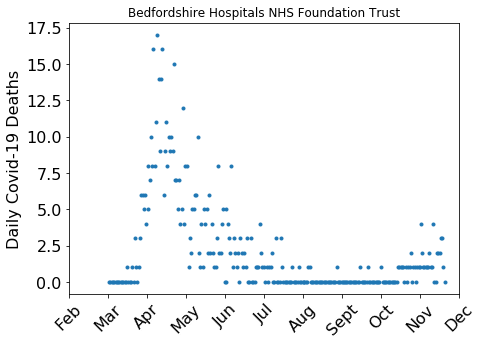

In [52]:
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

index = 4
days = np.array([date.day for date in dates])
months = np.array([date.month for date in dates])
years = np.array([date.year for date in dates])

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
ax.set_title(names[index], size = 12)
plot_dates = years + months/12 + days/365
ax.plot(plot_dates, deaths[index,:], ".")
ax.set_xlim(2020+2/12, 2021)
ax.set_xticks(2020+np.arange(2, 13)/12)
ax.set_xticklabels(month_names[1:], rotation = 45)
ax.set_ylabel("Daily Covid-19 Deaths")
plt.show()

## Save data

In [53]:
np.save("covid_deaths.npy", [dates, deaths])